In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
cols = ["chrom", "pos", "ref", "alt"]


def match_columns(df, target, covariates):
    pos = df[df[target]]
    neg = df[~df[target]]
    D = cdist(pos[covariates], neg[covariates])

    closest = []
    dists = []
    for i in tqdm(range(len(pos))):
        D[i, neg.chrom != pos.iloc[i].chrom] = np.inf  # ensure picking from same chrom
        j = np.argmin(D[i])
        closest.append(j)
        D[:, j] = np.inf  # ensure it cannot be picked up again
    return pd.concat([pos, neg.iloc[closest]])

In [3]:
genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")

Loading MSA...
Loading MSA... Done


In [4]:
from gpn.data import Tokenizer, ReverseComplementer
import gpn.model
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoModelForMaskedLM


class VEPEmbedding(torch.nn.Module):
    def __init__(self, model_path, embedding_mean=None, embedding_std=None):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_path)
        if embedding_mean is not None and embedding_std is not None:
            self.register_buffer("embedding_mean", torch.tensor(embedding_mean))
            self.register_buffer("embedding_std", torch.tensor(embedding_std))
        else:
            self.embedding_mean = None

    def get_embedding(self, input_ids, aux_features, exclude_pos=None):
        embedding = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).last_hidden_state
        
        if exclude_pos is not None:
            embedding = torch.cat((embedding[:, :exclude_pos], embedding[:, exclude_pos+1:]), dim=1)

        # chosing specific layer
        #hidden_states = self.model(
        #    input_ids=input_ids, aux_features=aux_features,
        #    output_hidden_states=True,
        #).hidden_states # note 0 is the encoder, so last layer is 12, not 11
        #embedding = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)  
            
        if self.embedding_mean is not None:
            embedding = (embedding - self.embedding_mean) / self.embedding_std
        
        # this usually on
        #embedding = embedding.reshape(len(input_ids), -1)
        
        return embedding
    
    def get_scores(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        embedding_ref = self.get_embedding(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        embedding_alt = self.get_embedding(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        return torch.stack((embedding_ref, embedding_alt), dim=1)
        return (
            F.pairwise_distance(embedding_ref, embedding_alt),
            (embedding_ref * embedding_alt).sum(dim=1),  # dot product
            F.cosine_similarity(embedding_ref, embedding_alt),
        )

    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]

        return torch.cat((
            self.get_scores(input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd),
            self.get_scores(input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev),
        ), dim=1)
        fwd1, fwd2, fwd3 = self.get_scores(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            #exclude_pos=W//2,
        )
        rev1, rev2, rev3 = self.get_scores(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            #exclude_pos=(W//2) - 1,
        )
        return torch.stack((
            (fwd1 + rev1) / 2,
            (fwd2 + rev2) / 2,
            (fwd3 + rev3) / 2,
        
        ), dim=1)


class VEPEmbeddingInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPEmbedding(model_path)#, embedding_mean=embedding_mean, embedding_std=embedding_std)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPEmbeddingInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred


def add_scores(V2):
    V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
    V2.euclidean_distance *= -1
    V2.cosine_similarity -= V2.cosine_similarity.max()
    V2.inner_product -= V2.inner_product.max()
    return V2

In [5]:
ldscore = pd.read_parquet("../../results/tmp/ldscore.processed.parquet")
ldscore

,chrom,pos,ref,alt,AF,ld_score
0,1,11063,T,G,0.000048,5.738593
1,1,13259,G,A,0.000278,5.048821
2,1,17641,G,A,0.000831,1.683291
3,1,57222,T,C,0.000659,2.475932
4,1,58396,T,C,0.00024,29.534102
...,...,...,...,...,...,...
22153592,X,155697134,G,A,0.000028,28.358136
22153593,X,155697920,G,A,0.302726,406.085388
22153594,X,155699751,C,T,0.245915,483.126375
22153595,X,155700569,A,G,0.246325,484.684299


In [6]:
ldscore["MAF"] = ldscore['AF'].apply(lambda x: min(x, 1-x))

In [7]:
pips = pd.read_parquet("../../results/tmp/my_pips.parquet")
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [8]:
"""
disease_traits = [
    'AFib',
    'AID_Combined',
    'Alzheimer_LTFH',
    'Asthma',
    'Blood_Clot_Lung',
    'BrC',
    'CAD',
    'Cholelithiasis',
    'CRC',
    'DVT',
    'Fibroblastic_Disorders',
    'Glaucoma_Combined',
    'Hypothyroidism',
    'IBD',
    'Inguinal_Hernia',
    'LOY',
    'MCP',
    'Migraine_Self',
    'PrC',
    'T2D',
    'T2D_BMI',
]

pips = pips[pips.trait.isin(disease_traits)]
pips
"""

"\ndisease_traits = [\n    'AFib',\n    'AID_Combined',\n    'Alzheimer_LTFH',\n    'Asthma',\n    'Blood_Clot_Lung',\n    'BrC',\n    'CAD',\n    'Cholelithiasis',\n    'CRC',\n    'DVT',\n    'Fibroblastic_Disorders',\n    'Glaucoma_Combined',\n    'Hypothyroidism',\n    'IBD',\n    'Inguinal_Hernia',\n    'LOY',\n    'MCP',\n    'Migraine_Self',\n    'PrC',\n    'T2D',\n    'T2D_BMI',\n]\n\npips = pips[pips.trait.isin(disease_traits)]\npips\n"

In [9]:
pips = pips[(~pips.LD_HWE) & (~pips.LD_SV)]
pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [10]:
# option 1
pips = pips[pips.method=="SUSIE"]

# option 2
#pips = pips.groupby(["chrom", "pos", "ref", "alt", "trait"]).agg({"method": "nunique", "pip": "mean", "maf": "mean"}).reset_index()
#pips = pips[pips.method==2]

pips

,chrom,pos,ref,alt,trait,method,pip,region,maf,LD_HWE,LD_SV
0,1,820055,T,G,IGF1,SUSIE,0.001039,chr1:708908-3708908,0.005550,False,False
1,1,832873,A,C,IGF1,SUSIE,0.003492,chr1:708908-3708908,0.236748,False,False
2,1,833068,G,A,CRP,SUSIE,0.004263,chr1:64194-3064194,0.106004,False,False
3,1,834583,G,A,CRP,SUSIE,0.004209,chr1:64194-3064194,0.105298,False,False
4,1,835506,G,A,CRP,SUSIE,0.004478,chr1:64194-3064194,0.104339,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4763178,22,50783624,G,A,Mono,SUSIE,0.001769,chr22:48513402-51304566,0.300835,False,False
4763179,22,50784537,G,A,Mono,SUSIE,0.001520,chr22:48513402-51304566,0.304649,False,False
4763180,22,50790482,G,A,Mono,SUSIE,0.003555,chr22:48513402-51304566,0.299990,False,False
4763181,22,50791289,A,T,Mono,SUSIE,0.003565,chr22:48513402-51304566,0.296184,False,False


In [11]:
# option 1
#pips_agg = pips.groupby(cols).agg({"pip": "sum", "maf": "mean", "trait": "count"}).reset_index().rename(columns={"trait": "n_traits"})
#pips_agg["pip"] = pips_agg.pip / len(pips.trait.unique())  # average pip

# option 2
pips_agg = pips.groupby(cols).agg({"pip": "max", "maf": "mean"}).reset_index()

pips_agg

,chrom,pos,ref,alt,pip,maf
0,1,820055,T,G,0.001039,0.005550
1,1,832873,A,C,0.003492,0.236748
2,1,833068,G,A,0.004263,0.106004
3,1,834583,G,A,0.004209,0.105298
4,1,835506,G,A,0.004478,0.104339
...,...,...,...,...,...,...
1632740,9,138172038,C,T,0.001342,0.372683
1632741,9,138173218,G,A,0.045044,0.165755
1632742,9,138174172,T,C,0.001422,0.372984
1632743,9,138174508,T,C,0.001392,0.399574


In [12]:
models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa",
    "CADD.RawScore",
    "phyloP",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/upweight_phyloP_and_phastCons_flip_0.1_0.5_msa": "GPN-MSA",
}

V = pd.read_parquet("../../results/finemapping/processed/test.parquet")
d = Path(f"../../results/preds/results/finemapping/processed")
for m in models:
    model_name = model_renaming.get(m, m)
    if m in V.columns:
        V.rename(columns={m: model_name}, inplace=True)
        continue
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP
0,1,832873,A,C,0.487101,0.145778,0.677
1,1,833068,G,A,1.751498,0.016390,-0.036
2,1,834583,G,A,0.339468,0.051453,0.479
3,1,835506,G,A,-0.253357,0.177210,0.645
4,1,841852,C,T,0.046023,0.025537,0.459
...,...,...,...,...,...,...,...
1821943,22,50783624,G,A,-0.883718,-0.438139,0.932
1821944,22,50784537,G,A,0.073284,-0.645151,-0.249
1821945,22,50790482,G,A,0.051396,0.020462,-0.349
1821946,22,50791289,A,T,-0.813960,-0.261473,-0.062


In [13]:
V = V.merge(ldscore, on=cols, how="inner")
V

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF
0,1,832873,A,C,0.487101,0.145778,0.677,0.763689,65.233773,0.236311
1,1,833068,G,A,1.751498,0.016390,-0.036,0.105508,39.035791,0.105508
2,1,834583,G,A,0.339468,0.051453,0.479,0.104803,39.16434,0.104803
3,1,835506,G,A,-0.253357,0.177210,0.645,0.103867,38.977357,0.103867
4,1,841852,C,T,0.046023,0.025537,0.459,0.095105,39.579469,0.095105
...,...,...,...,...,...,...,...,...,...,...
1816798,22,50783624,G,A,-0.883718,-0.438139,0.932,0.299913,38.986375,0.299913
1816799,22,50784537,G,A,0.073284,-0.645151,-0.249,0.30374,39.121952,0.303740
1816800,22,50790482,G,A,0.051396,0.020462,-0.349,0.299102,37.73791,0.299102
1816801,22,50791289,A,T,-0.813960,-0.261473,-0.062,0.295325,37.576431,0.295325


In [14]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [15]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9887593756725412

In [16]:
V = V[not_na]
V.shape

(1796381, 10)

## Aggregate

In [17]:
from scipy.stats import zscore

V2 = V.merge(pips_agg, how="inner", on=cols).sort_values("pip", ascending=False)
V2["maf_z"] = zscore(V2["maf"])
V2["ld_score_z"] = zscore(V2["ld_score"].astype(float))

# option 1
#V2.loc[V2.pip.rank(ascending=False) <= 1000, "Likely causal"] = True   # 1000
#V2.loc[V2.pip.rank() <= 100_000, "Likely causal"] = False  # 100_000

# option 2
V2.loc[V2.pip > 0.99, "Likely causal"] = True
V2.loc[V2.pip < 0.01, "Likely causal"] = False

V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    1248001
True        1460
Name: count, dtype: int64

In [21]:
V2 = match_columns(
    V2, "Likely causal",
    [
        "maf_z",
        "ld_score_z"
    ]
)
V2 = V2.drop_duplicates()
V2["Likely causal"].value_counts()

100%|██████████| 1460/1460 [01:35<00:00, 15.25it/s]


Likely causal
True     1460
False    1460
Name: count, dtype: int64

In [26]:
n = len(V2) // 2

In [22]:
X = score_vep(V2)
X.shape

(2920, 4, 128, 768)

In [31]:
delta_norm_fwd = np.linalg.norm(X[:, 1] - X[:, 0], axis=1)
delta_norm_rev = np.linalg.norm(X[:, 3] - X[:, 2], axis=1)
delta_norm = 0.5 * (delta_norm_fwd + delta_norm_rev)
delta_norm_fwd.shape

(2920, 768)

In [32]:
inner_product_fwd = np.sum(X[:, 1] * X[:, 0], axis=1)
inner_product_rev = np.sum(X[:, 3] * X[:, 2], axis=1)
inner_product = 0.5 * (inner_product_fwd + inner_product_rev)
inner_product_fwd.shape

(2920, 768)

In [36]:
idx_train = V2.chrom=="1"
V2_train = V2[idx_train].copy()
V2_train

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,maf_z,ld_score_z,Likely causal
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,1.000000,0.051695,-0.975603,-0.378455,True
51480,1,68191014,T,C,-1.999459,0.141774,2.848,0.376974,49.184288,0.376974,1.000000,0.376509,1.102970,-0.716647,True
113476,1,203312047,G,C,-4.904123,-1.497961,-1.468,0.535537,45.369396,0.464463,1.000000,0.464235,1.664355,-0.741589,True
42834,1,55039974,G,T,-0.703061,-0.900304,0.775,0.017642,13.095364,0.017642,1.000000,0.017696,-1.193171,-0.952594,True
71211,1,109690361,A,G,-2.061565,-0.007160,-0.627,0.730649,32.277545,0.269351,1.000000,0.269205,0.416305,-0.827182,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88554,1,159723815,G,A,-0.708723,-0.069636,-0.171,0.329321,69.149679,0.329321,0.007600,0.329688,0.803353,-0.586115,False
6079,1,6698032,C,T,-1.330021,0.270782,0.293,0.010201,13.504693,0.010201,0.001809,0.010298,-1.240515,-0.949917,False
71480,1,109917220,C,T,-2.608046,-0.083232,0.036,0.003162,6.17958,0.003162,0.004683,0.003170,-1.286129,-0.997808,False
74257,1,112542553,G,T,-2.203135,0.254644,0.778,0.209305,148.181623,0.209305,0.004697,0.208095,0.025247,-0.069412,False


In [37]:
X_train = inner_product[idx_train]
X_train.shape

(298, 768)

In [41]:
X_test = inner_product[~idx_train]
X_test.shape

(2622, 768)

In [43]:
y_train = V2_train["Likely causal"].astype(float).values
y_train

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [44]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=42).fit(X_train, y_train)
clf

LogisticRegression(random_state=42)

In [61]:
pred = clf.predict_log_proba(X_test)[:, 0]
pred.shape

(2622,)

In [71]:
n = len(V2_train)//2

results_train = []
for m in range(768):
    #score = -delta_norm[:, m]
    score = X_train[:, m]
    #score = inner_product[:, sorted_indices[:10]].mean(axis=1)
    results_train.append([
        m,
        roc_auc_score(V2_train["Likely causal"], -score),
        average_precision_score(V2_train["Likely causal"], -score),
        np.mean([(score[i] < score[i+n]) for i in range(n)]),
    ])
results_train = pd.DataFrame(results_train, columns=["Model", "AUROC", "AUPRC", "Pairwise_accuracy"])
results_train

,Model,AUROC,AUPRC,Pairwise_accuracy
0,0,0.608126,0.551382,0.597315
1,1,0.374803,0.440382,0.375839
2,2,0.348002,0.422437,0.328859
3,3,0.370254,0.440157,0.355705
4,4,0.409756,0.441674,0.409396
...,...,...,...,...
763,763,0.377731,0.432189,0.335570
764,764,0.406153,0.432258,0.375839
765,765,0.667628,0.644030,0.664430
766,766,0.457682,0.448677,0.469799


In [72]:
results_train.sort_values("Pairwise_accuracy", ascending=False)

,Model,AUROC,AUPRC,Pairwise_accuracy
684,684,0.742129,0.761568,0.765101
132,132,0.723030,0.694146,0.751678
748,748,0.737174,0.749024,0.751678
454,454,0.732985,0.715317,0.744966
759,759,0.707986,0.722064,0.744966
...,...,...,...,...
173,173,0.314265,0.390672,0.255034
707,707,0.279672,0.382394,0.248322
381,381,0.277735,0.384959,0.248322
624,624,0.270033,0.377722,0.241611


In [73]:
sorted_indices = results_train.sort_values("Pairwise_accuracy", ascending=False).Model.values
sorted_indices

array([684, 132, 748, 454, 759, 208, 276, 477, 243,  95, 695, 217, 267,
       597, 590, 575, 353, 360, 512, 501,  39, 579, 241, 761, 735, 302,
       177, 541, 517, 661, 578, 172,  72, 233, 701, 455, 297, 676, 663,
        41,  34, 191, 523, 196, 531,  90, 615, 495, 643, 475, 408, 510,
       109, 367, 318, 600, 525, 235, 700,  49, 535, 629, 107, 691, 354,
       327, 358, 765, 472, 739, 108, 390, 654, 401, 164, 714, 301, 375,
       136, 289, 552, 447, 269, 295, 112, 434, 446, 102, 741, 129, 239,
       604, 635, 234, 520, 200, 709, 149, 386, 740,  28, 720, 334, 179,
       674,  97, 199, 655, 326, 746, 414, 210, 169, 496,  94, 176, 409,
       704, 115, 340, 529, 681,  16, 150, 328, 281, 111, 299, 749, 457,
       568, 311, 744, 113, 599, 412, 293, 119, 417, 651, 670, 415, 223,
       557, 160, 254,  13, 262, 290, 232, 240, 174, 330,   0,  64,  76,
       397, 122, 569, 581, 722, 560, 617, 430, 123,  17, 279, 163, 201,
       168,  46, 558, 750, 653, 667, 103, 616, 158, 118, 688, 19

In [84]:
best_indices = results[results.Pairwise_accuracy > 0.7].Model.values
best_indices

array([ 72,  95, 132, 208, 217, 233, 241, 243, 267, 276, 302, 408, 454,
       455, 501, 531, 541, 575, 579, 590, 597, 661, 676, 684, 701, 720,
       735, 748, 759, 761])

<Axes: >

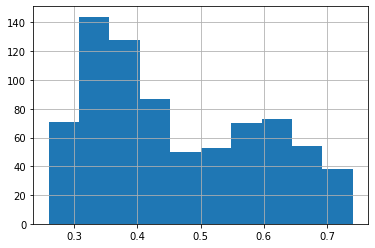

In [79]:
results.Pairwise_accuracy.hist()

In [71]:
V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
V2

ValueError: Must have equal len keys and value when setting with an iterable

In [49]:
V2 = V2[~idx_train]

In [92]:
models = ["GPN-MSA", "CADD", "phyloP"]

In [93]:
V2["inner_product_select_dimensions"] = X_test[:, sorted_indices[:10]].mean(axis=1)
models.append("inner_product_select_dimensions")
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,maf_z,ld_score_z,Likely causal,new_score,inner_product_select_dimensions
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,1.000000,0.008051,-1.254893,-0.819434,True,122.825912,122.825912
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,1.000000,0.051959,-0.973912,-0.847817,True,105.007042,105.007042
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,1.000000,0.022357,-1.163349,-0.863490,True,250.139572,250.139572
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,1.000000,0.006824,-1.262746,-0.927246,True,112.229736,112.229736
1046995,11,92975544,C,G,-2.853292,-0.184331,-0.272,0.275261,65.198771,0.275261,1.000000,0.275090,0.453964,-0.611946,True,239.504120,239.504120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997535,11,12166836,T,C,-3.710692,-1.069643,-0.918,0.067593,20.465612,0.067593,0.001519,0.067763,-0.872780,-0.904408,False,157.787521,157.787521
504243,5,58057758,T,A,-1.696317,-0.118311,0.098,0.456755,147.323308,0.456755,0.005721,0.456479,1.614724,-0.075023,False,311.852112,311.852112
452837,4,104500049,T,A,-3.496934,0.127834,0.278,0.062297,58.101165,0.062297,0.001206,0.062532,-0.906255,-0.658350,False,225.256256,225.256256
1025430,11,63078422,G,A,-0.570004,-0.281351,-0.089,0.518992,196.941613,0.481008,0.002933,0.481307,1.773606,0.249377,False,425.567871,425.567871


In [22]:
models += ["euclidean_distance", "inner_product", "cosine_similarity"]

In [23]:
V2.euclidean_distance *= -1
V2.cosine_similarity -= V2.cosine_similarity.max()
V2.inner_product -= V2.inner_product.max()
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,pip,maf,maf_z,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,1.000000,0.008051,-1.254893,-0.819434,True,-35.971123,-767.117188,-0.006484
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,1.000000,0.051959,-0.973912,-0.847817,True,-26.772373,-565.656250,-0.003568
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,1.000000,0.051695,-0.975603,-0.378455,True,-8.553123,-57.203125,-0.000309
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,1.000000,0.022357,-1.163349,-0.863490,True,-7.425867,-45.250000,-0.000218
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,1.000000,0.006824,-1.262746,-0.927246,True,-21.398685,-381.031250,-0.002258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136708,1,234490133,C,G,-3.501112,-0.259817,-0.479,0.067282,20.121107,0.067282,0.003653,0.066970,-0.877855,-0.906660,False,-25.392609,-314.101562,-0.003196
1319590,16,20975184,C,T,-0.160268,0.396571,0.732,0.456484,143.972223,0.456484,0.001057,0.456755,1.616490,-0.096932,False,-13.685951,-180.757812,-0.000889
577450,6,402087,T,C,-1.455455,-0.021822,0.342,0.063275,57.37736,0.063275,0.001426,0.062803,-0.904521,-0.663082,False,-11.365932,-91.945312,-0.000592
1502544,19,38673824,C,T,-0.301022,-0.101097,-0.292,0.484215,196.600375,0.484215,0.007927,0.484662,1.795077,0.247146,False,-20.381060,-382.687500,-0.002041


In [104]:
V2[models].corr(method="spearman")

,GPN-MSA,CADD,phyloP,new_score
GPN-MSA,1.000000,0.663698,0.630908,0.603599
CADD,0.663698,1.000000,0.832223,0.570614
phyloP,0.630908,0.832223,1.000000,0.448859
new_score,0.603599,0.570614,0.448859,1.000000


In [105]:
def rank_transform(s):
    return -(s.rank(ascending=False))

for m in ["new_score"]:#["euclidean_distance", "inner_product", "cosine_similarity"]:#, "JSD"]:
    V2[f"rank(LLR)+rank({m})"] = rank_transform(V2["GPN-MSA"]) + rank_transform(V2[m])
    models.append(f"rank(LLR)+rank({m})")
V2

,chrom,pos,ref,alt,GPN-MSA,CADD,phyloP,AF,ld_score,MAF,...,ld_score_z,Likely causal,euclidean_distance,inner_product,cosine_similarity,rank(LLR)+rank(euclidean_distance),rank(LLR)+rank(inner_product),rank(LLR)+rank(cosine_similarity),new_score,rank(LLR)+rank(new_score)
730162,7,100711557,A,G,-4.309961,-2.050949,-1.805,0.008014,33.462704,0.008014,...,-0.819434,True,-35.971123,-767.117188,-0.006484,-5293.0,-5262.0,-5291.0,115.201187,-4873.0
1334366,16,56973441,C,T,-2.039262,-0.226205,0.649,0.052227,29.121443,0.052227,...,-0.847817,True,-26.772373,-565.656250,-0.003568,-4658.0,-4607.0,-4654.0,99.218292,-4716.0
90185,1,161642443,T,C,-1.380076,-0.412836,-0.373,0.051882,100.912211,0.051882,...,-0.378455,True,-8.553123,-57.203125,-0.000309,-1894.0,-1873.0,-1888.0,245.960495,-2584.0
212960,2,110994574,T,C,-1.315349,-0.326347,-0.193,0.022127,26.724134,0.022127,...,-0.863490,True,-7.425867,-45.250000,-0.000218,-1575.0,-1560.0,-1573.0,264.531342,-2083.0
1044656,11,86942946,G,A,-3.279128,-1.840191,-1.223,0.006674,16.972427,0.006674,...,-0.927246,True,-21.398685,-381.031250,-0.002258,-4466.0,-4496.0,-4461.0,111.031776,-4773.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136708,1,234490133,C,G,-3.501112,-0.259817,-0.479,0.067282,20.121107,0.067282,...,-0.906660,False,-25.392609,-314.101562,-0.003196,-4915.0,-4256.0,-4906.0,268.463196,-3078.0
1319590,16,20975184,C,T,-0.160268,0.396571,0.732,0.456484,143.972223,0.456484,...,-0.096932,False,-13.685951,-180.757812,-0.000889,-1549.0,-1734.0,-1542.0,186.633621,-2144.0
577450,6,402087,T,C,-1.455455,-0.021822,0.342,0.063275,57.37736,0.063275,...,-0.663082,False,-11.365932,-91.945312,-0.000592,-2445.0,-2453.0,-2442.0,217.060059,-3180.0
1502544,19,38673824,C,T,-0.301022,-0.101097,-0.292,0.484215,196.600375,0.484215,...,0.247146,False,-20.381060,-382.687500,-0.002041,-2490.0,-2643.0,-2486.0,352.406555,-685.0


In [94]:
n = len(V2)//2

results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V2["Likely causal"], -V2[m]),
        average_precision_score(V2["Likely causal"], -V2[m]),
        np.mean([(V2.iloc[i][m] < V2.iloc[i+n][m]) for i in range(n)]),
    ])
results = pd.DataFrame(results, columns=[
    "Model",
    "AUROC",
    "AUPRC",
    "Pairwise_accuracy"
])
results

,Model,AUROC,AUPRC,Pairwise_accuracy
0,GPN-MSA,0.680418,0.733148,0.683448
1,CADD,0.697107,0.757173,0.700992
2,phyloP,0.645999,0.701703,0.668192
3,inner_product_select_dimensions,0.758773,0.766407,0.768116


<Axes: xlabel='Pairwise_accuracy', ylabel='Model'>

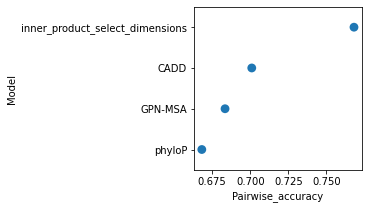

In [95]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("Pairwise_accuracy", ascending=False),
    y="Model",
    x="Pairwise_accuracy",
    join=False,
)

<Axes: xlabel='AUROC', ylabel='Model'>

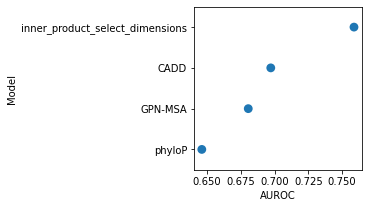

In [96]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False),
    y="Model",
    x="AUROC",
    join=False,
)